In [1]:
from math import pi
import numpy as np
from collections import OrderedDict

import matplotlib.pyplot as plt
import matplotlib.colors as pcl
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D

import time

from LRvismod3d import *
from basicFun import readparm

# Homogeneous example: ABCs test

In [2]:
offset_xs = 40 # x distance of the source
offset_ys = 100 # y distance of the source
offset_zs = 40 # depth of the source
theta = np.array([0,25,50,75]) # tested incident angles of outgoing waves
offset_yr = offset_ys+np.array(np.tan(theta/180*pi)*40,dtype=np.int16) # calculated y offset
print(f'Tested angles: {theta}')
print(f'Distance of corresponding receivers along y direction: {offset_yr}')

Tested angles: [ 0 25 50 75]
Distance of corresponding receivers along y direction: [100 118 147 249]


In [3]:
# define a specific 3-D snapshot display function
def show3Dnew(md, xyz, xyzi, clim):
    
    # slice given index image along each dimension
    mx = md[xyzi[0],:,:].transpose()
    my = md[:,xyzi[1],:].transpose()
    mz = md[:,:,xyzi[2]].transpose()
    cN = pcl.Normalize(vmin=clim[0], vmax=clim[1])
    rg = [clim[0],clim[1]-clim[0]]
    
    # plot the model
    fig = plt.figure(figsize = (15,5))
    ax = fig.gca(projection='3d')
    
    # plot the indicator line
    xi = xyz[0][xyzi[0]]
    yi = xyz[1][xyzi[1]]
    zi = xyz[2][xyzi[2]]
    ax.plot([xi,xi],[xyz[1][0],xyz[1][0]],[xyz[2][0],xyz[2][-1]],'r-',linewidth=2,zorder=10)
    ax.plot([xi,xi],[xyz[1][0],xyz[1][-1]],[xyz[2][0],xyz[2][0]],'r-',linewidth=2,zorder=10)
    ax.plot([xyz[0][0],xyz[0][0]],[yi,yi],[xyz[2][0],xyz[2][-1]],'r-',linewidth=2,zorder=10)
    ax.plot([xyz[0][0],xyz[0][-1]],[yi,yi],[xyz[2][0],xyz[2][0]],'r-',linewidth=2,zorder=10)
    ax.plot([xyz[0][0],xyz[0][-1]],[xyz[2][0],xyz[2][0]],[zi,zi],'r-',linewidth=2,zorder=10)
    ax.plot([xyz[0][0],xyz[0][0]],[xyz[1][0],xyz[1][-1]],[zi,zi],'r-',linewidth=2,zorder=10)
    
    # plot the three surfaces
    ax = slice_show(ax, mz, xyz, 0, rg=rg)
    ax = slice_show(ax, mx, xyz, 1, rg=rg)
    ax = slice_show(ax, my, xyz, 2, rg=rg)
    
    # set the axes
    xtick = np.linspace(xyz[0][0],xyz[0][-1],3)
    ytick = np.linspace(xyz[1][0],xyz[1][-1],5)
    ztick = np.linspace(xyz[2][0],xyz[2][-1],3)
    ax.set_xticks(xtick)
    ax.set_xticklabels([f'{int(i)}' for i in xtick],fontsize=12)
    ax.set_yticks(ytick)
    ax.set_yticklabels([f'{int(i)}' for i in ytick],fontsize=12)
    ax.set_zticks(ztick)
    ax.set_zticklabels([f'{int(i)}' for i in ztick],fontsize=12)
    ax.invert_zaxis()
    ax.invert_xaxis()
    ax.view_init(elev=30,azim=-15)
    
    # set the labels
    ax.text(100, -2100, 1600, 'x (m)', (1,-0.8,0), fontsize=15)
    ax.text(-900, 1900, 1600, 'y (m)', (-0.08,1,0), fontsize=15)
    ax.text(0, 7300, 1200, 'z (m)', (0,0,1), fontsize=15)
    
    
    # colorbar
    cb = fig.colorbar(cm.ScalarMappable(norm=cN, cmap='bwr'))
    ctick = np.linspace(clim[0],clim[1],5)
    cb.set_ticks(ctick)
    cb.set_ticklabels([f'{i*1e3:.1f}' for i in ctick])
    cb.ax.tick_params(labelsize=15)
    
    plt.show()

    return fig, ax

def slice_show(ax, ms, xyz, od, rg=None, offset=0, rcstride=(1,1)):
    if rg is None:
        shift = np.amin(ms)
        normalizer = np.amax(ms)-shift
    else:
        shift = rg[0]
        normalizer = rg[1]
    if normalizer == 0:
        msN = np.zeros_like(ms)+0.5
    else:
        msN = (ms-shift)/normalizer
    colors = plt.cm.bwr(msN)
    if od == 0:
        [X,Y] = np.meshgrid(xyz[0],xyz[1])
        Z = np.zeros_like(X)+xyz[2][0]+offset
    if od == 1:
        [Y,Z] = np.meshgrid(xyz[1],xyz[2])
        X = np.zeros_like(Y)+xyz[0][0]+offset
    if od == 2:
        [X,Z] = np.meshgrid(xyz[0],xyz[2])
        Y = np.zeros_like(X)+xyz[1][0]+offset
    surf = ax.plot_surface(X, Y, Z, 
                           facecolors=colors, rstride=rcstride[0], cstride=rcstride[1], zorder=1)
    
    return ax

In [4]:
# define pathes
inpath = './resources/hme_abc'
outpath = './outputs/AGUpaper'

In [5]:
r'''V = np.zeros((81,301,81))+2000
V = np.array(np.reshape(V,(81,301,81),'F'),dtype = '>f4')
V.tofile(f'{inpath}/v.dat')'''

"V = np.zeros((81,301,81))+2000\nV = np.array(np.reshape(V,(81,301,81),'F'),dtype = '>f4')\nV.tofile(f'{inpath}/v.dat')"

In [6]:
r'''Q = np.zeros((81,301,81))+100
Q = np.array(np.reshape(Q,(81,301,81),'F'),dtype = '>f4')
Q.tofile(f'{inpath}/Q.dat')'''

"Q = np.zeros((81,301,81))+100\nQ = np.array(np.reshape(Q,(81,301,81),'F'),dtype = '>f4')\nQ.tofile(f'{inpath}/Q.dat')"

In [7]:
# readin basic parm
basic_parm = readparm(inpath)

Temporal step length (dt/s):

0.002

Recording time steps (nt/1):

1001

Reference frequency (f0/Hz):

20

Low rank decomposition number along x (ln):

2

Low rank decomposition number along k (lm):

2


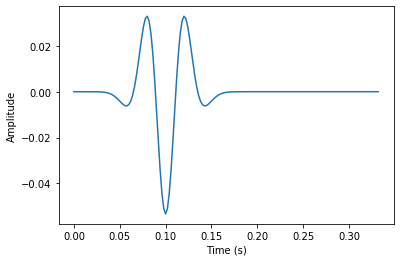

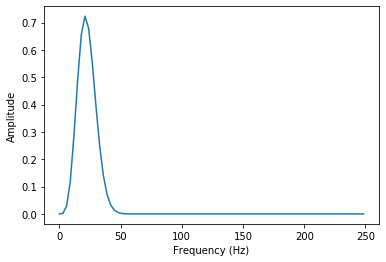

In [8]:
# create source class
nt = basic_parm[1]
dt = basic_parm[0]
fs = 15 # dominant frequency of Ricker wavelet
t0 = -1.5/fs
sl = round(5/fs/dt)
s = source(fs, dt, t0, sl, order=2, tol=1e-2)
s.ws = np.linspace(5.0,50.0,10)*2*pi # define the source valid frequency samples

In [9]:
v = model('velocity.h', inpath, f0=basic_parm[2])
Q = model('Qaulity_factor.h', inpath)

In [10]:
# create source and reciever indices
def createids():
    indx = [offset_xs]
    indy = [offset_ys]
    indz = [offset_zs]
    tmp = OrderedDict(x=indx,
                       y=indy,
                       z=indz)
    ids = np.array([v for v in product(*tmp.values())],dtype=np.int16)
    return ids

def createidr():
    indx = [offset_xs]
    indy = offset_yr
    indz = [5]
    tmp = OrderedDict(x=indx,
                       y=indy,
                       z=indz)
    idr = np.array([v for v in product(*tmp.values())],dtype=np.int16)
    return idr  

ids = createids()
idr = createidr()

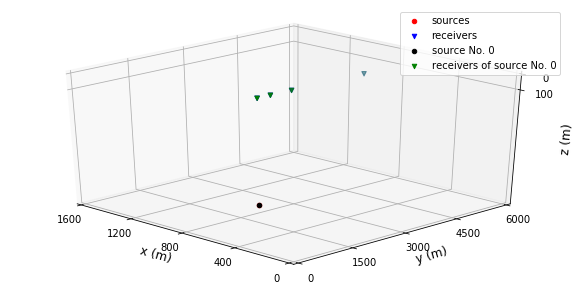

In [11]:
# test acqgeo class
geometry = acqgeo(ids, idr)
# display the acquisation geometry
geometry.geometry_show(v.x,v.y,v.z,ea=(30,-45))

In [12]:
# test modeling class
vmh = 'velocity.h'
Qmh = 'Qaulity_factor.h'

In [13]:
# set the clim for snapshots
# when test for computational time, let tsample=[], since the snapshot display and saving cost some time
# when display the snapshots, let tsample = [400,800]
tsample = [400,800]

## (1) Natural-attenuation absorbing boundary condition $\varepsilon=0.04$

In [14]:
LRM = LRmodeling(basic_parm,s,geometry,vmh,Qmh,typ_tsc=2,abc={'naABCs':0.04},inpath=inpath,outpath=outpath)

Model expanding for naABC...
Total No. of unique roundup (v,g) pairs: 1.


[========================================================================] 100%


Plane boundary expanding...
Edge boundary expanding...
Corner boundary expanding...
Absorbing layer No: 17
Runtime for preparing ABCs: 6.842506408691406 s
Low-rank decomposition...
Ws for W1
RRQR for Ws
Principal Px combinations:[[2.0000000e+03 3.1829926e-03]
 [1.9518346e+03 2.8292334e-01]]
Ws for W2
RRQR for Ws
Principal K components:[0.27022296 0.16754591]
Ws for W1
RRQR for Ws
Principal Px combinations:[[2.0000000e+03 3.1829926e-03]
 [1.9518346e+03 2.8292334e-01]]
Ws for W2
RRQR for Ws
Principal K components:[0.27022296 0.11583295]
Runtime for low-rank decomposition: 1.2407865524291992 s
Model parameter calculation...
Modeling preparation done!


Source No. progress:
Time progress:


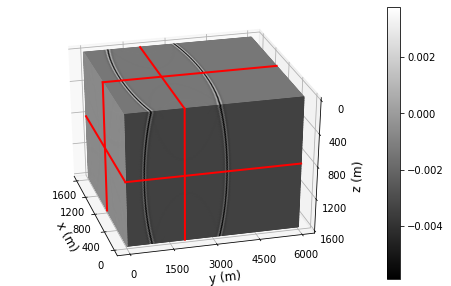

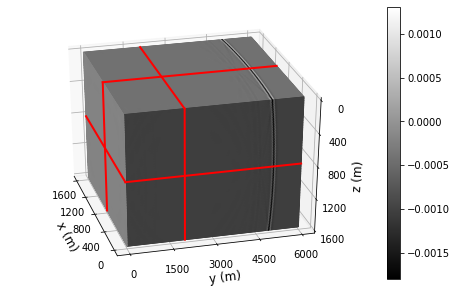

[========================================================================] 100%


29.95890736579895


In [15]:
st = time.time()
rec,_,_ = LRM.LRiteration(tsample=tsample,clim=None) # if test efficiency, set tsample=[]
T = time.time()-st
print(T)

In [16]:
rec004 = rec

In [17]:
# save the record
fna1 = 'rec_naabc_004.dat'
rec004.tofile(f'{outpath}/{fna1}')

0.0059769144


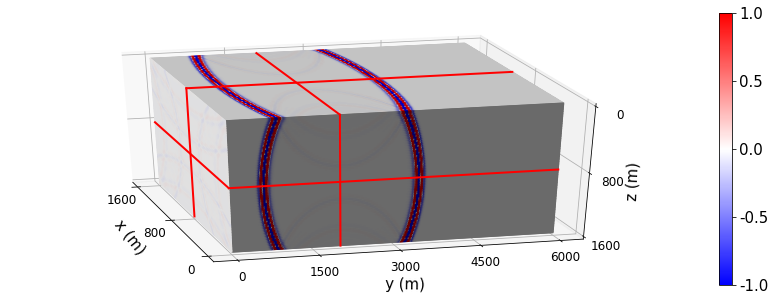

0.0021928796


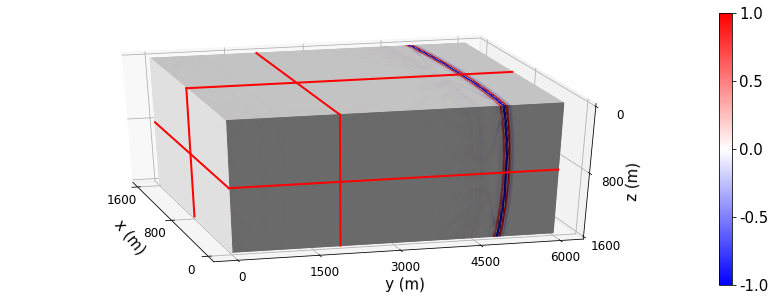

In [18]:
clim = np.array([-1,+1])*1e-3
# readin the sampled snapshots
if tsample is not None:
    fig = []
    for it in tsample:
        sp = np.fromfile(f'{outpath}/snapshot_it={it}.dat',dtype=np.float32)
        sp = np.reshape(sp,v.n)
        print(np.amax(np.abs(sp)))
        figt, _ = show3Dnew(sp, [v.x,v.y,v.z], ids[0], clim=clim)
        fig.append(figt)

In [19]:
# save the snapshots
nf = len(fig)
fnfig = 'hme_naabc004'
for i in range(nf):
    fig[i].savefig(f'{outpath}/{fnfig}_{tsample[i]}.png',dpi=600)

## (2) Natural-attenuation absorbing boundary condition $\varepsilon=0.01$

In [20]:
LRM = LRmodeling(basic_parm,s,geometry,vmh,Qmh,typ_tsc=2,abc={'naABCs':0.01},inpath=inpath,outpath=outpath)

Model expanding for naABC...
Total No. of unique roundup (v,g) pairs: 1.


[========================================================================] 100%


Plane boundary expanding...
Edge boundary expanding...
Corner boundary expanding...
Absorbing layer No: 33
Runtime for preparing ABCs: 9.947275400161743 s
Low-rank decomposition...
Ws for W1
RRQR for Ws
Principal Px combinations:[[2.0000000e+03 3.1829926e-03]
 [1.9026042e+03 3.0587432e-01]]
Ws for W2
RRQR for Ws
Principal K components:[0.27058942 0.16795366]
Ws for W1
RRQR for Ws
Principal Px combinations:[[2.0000000e+03 3.1829926e-03]
 [1.9026042e+03 3.0587432e-01]]
Ws for W2
RRQR for Ws
Principal K components:[0.27058942 0.11632658]
Runtime for low-rank decomposition: 1.8921313285827637 s
Model parameter calculation...
Modeling preparation done!


Source No. progress:
Time progress:


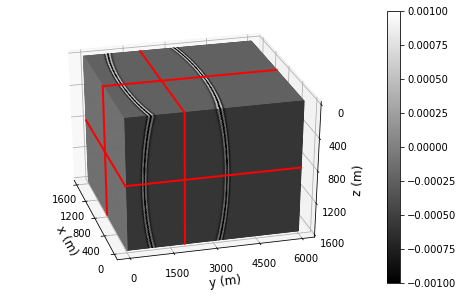

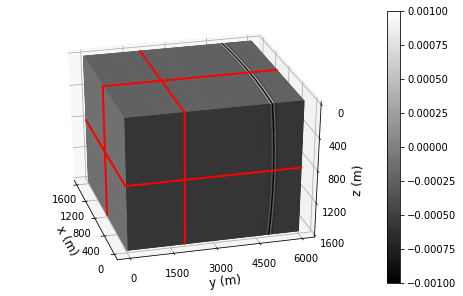

[========================================================================] 100%


40.58393716812134


In [21]:
st = time.time()
rec,fig,ax = LRM.LRiteration(tsample=tsample,clim=clim) # if test efficiency, set tsample=[]
T = time.time()-st
print(T)

In [22]:
rec001 = rec

In [23]:
# save the record
fna2 = 'rec_naabc_001.dat'
rec001.tofile(f'{outpath}/{fna2}')

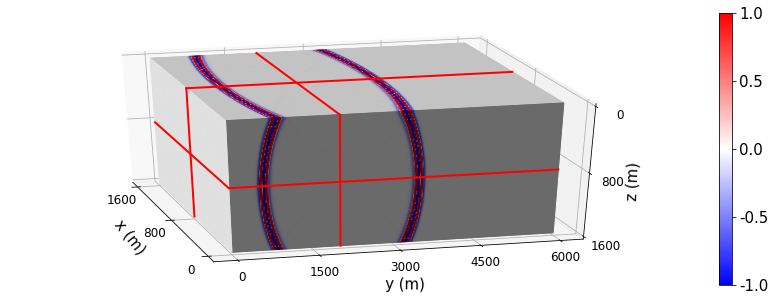

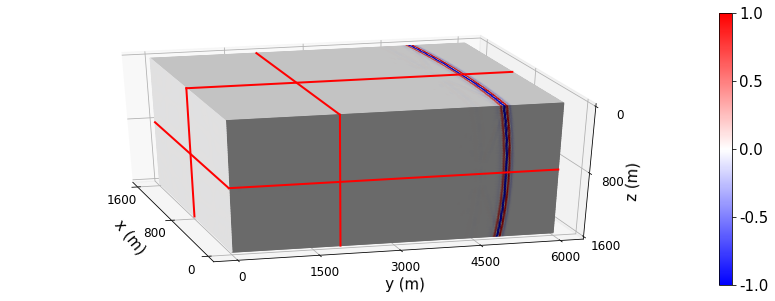

In [24]:
# readin the sampled snapshots
if tsample is not None:
    fig = []
    for it in tsample:
        sp = np.fromfile(f'{outpath}/snapshot_it={it}.dat',dtype=np.float32)
        sp = np.reshape(sp,v.n)
        figt, _ = show3Dnew(sp, [v.x,v.y,v.z], ids[0], clim=clim)
        fig.append(figt)

In [25]:
# save the snapshots
nf = len(fig)
fnfig = 'hme_naabc001'
for i in range(nf):
    fig[i].savefig(f'{outpath}/{fnfig}_{tsample[i]}.png',dpi=600)

## (3) Hybrid abosrbing bundary condition ($N=20$)

In [26]:
LRM = LRmodeling(basic_parm,s,geometry,vmh,Qmh,typ_tsc=2,abc={'hABCs':20},inpath=inpath,outpath=outpath)

Model expanding for hABC...
Plane No: 1
Plane No: 2
Plane No: 3
Plane No: 4
Plane No: 5
Plane No: 6
Edge No: 1
Edge No: 2
Edge No: 3
Edge No: 4
Edge No: 5
Edge No: 6
Edge No: 7
Edge No: 8
Edge No: 9
Edge No: 10
Edge No: 11
Edge No: 12
Corner No: 1
Corner No: 2
Corner No: 3
Corner No: 4
Corner No: 5
Corner No: 6
Corner No: 7
Corner No: 8
Absorbing layer No: 20
Runtime for preparing ABCs: 1.7823255062103271 s
Low-rank decomposition...
Ws for W1
RRQR for Ws
Principal Px combinations:[[2.0000000e+03 3.1829926e-03]
 [2.0000000e+03 3.1829926e-03]]
Ws for W2
RRQR for Ws
Principal K components:[0.27030581 0.2576454 ]
Ws for W1
RRQR for Ws
Principal Px combinations:[[2.0000000e+03 3.1829926e-03]
 [2.0000000e+03 3.1829926e-03]]
Ws for W2
RRQR for Ws
Principal K components:[0.27030581 0.25453699]
Runtime for low-rank decomposition: 1.1873657703399658 s
Model parameter calculation...
Modeling preparation done!


Source No. progress:
Time progress:


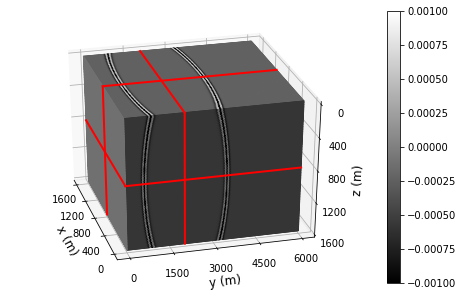

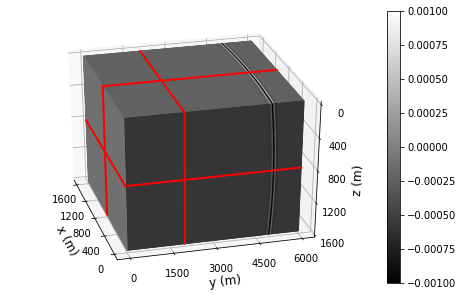

[========================================================================] 100%


80.44231081008911


In [27]:
st = time.time()
rec,fig,ax = LRM.LRiteration(tsample=tsample,clim=clim) # if test efficiency, set tsample=[]
T = time.time()-st
print(T)

In [28]:
rech20 = rec

In [29]:
# save the record
fnh2 = 'rec_habc_20.dat'
rech20.tofile(f'{outpath}/{fnh2}')

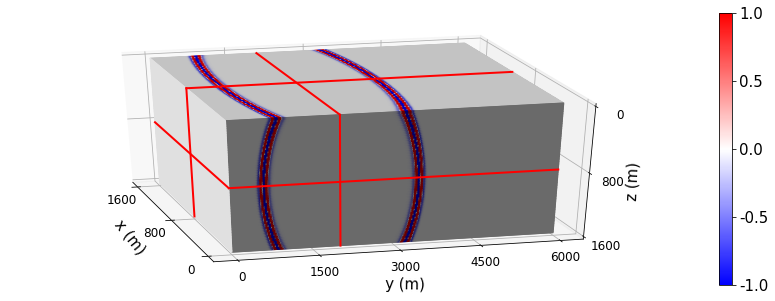

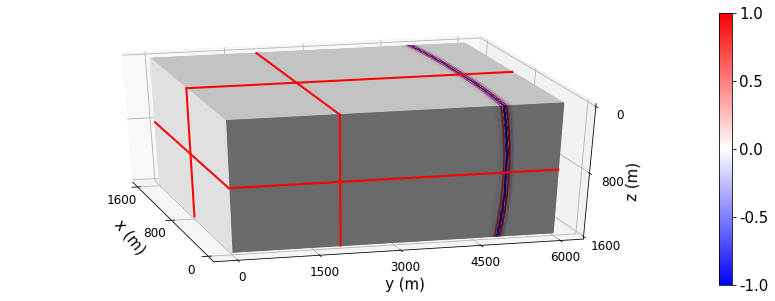

In [30]:
# readin the sampled snapshots
if tsample is not None:
    fig = []
    for it in tsample:
        sp = np.fromfile(f'{outpath}/snapshot_it={it}.dat',dtype=np.float32)
        sp = np.reshape(sp,v.n)
        figt, _ = show3Dnew(sp, [v.x,v.y,v.z], ids[0], clim=clim)
        fig.append(figt)

In [31]:
# save the snapshots
nf = len(fig)
fnfig = 'hme_habc20'
for i in range(nf):
    fig[i].savefig(f'{outpath}/{fnfig}_{tsample[i]}.png',dpi=600)

## (5) Reference solution (by expanding modeling area)

In [32]:
# test the truncated overthrust model
inpath = './resources/hme_abc_expand'

In [33]:
r'''V = np.zeros((401,401,401))+2000
V = np.array(np.reshape(V,(401,401,401),'F'),dtype = '>f4')
V.tofile(f'{inpath}/v.dat')'''

"V = np.zeros((401,401,401))+2000\nV = np.array(np.reshape(V,(401,401,401),'F'),dtype = '>f4')\nV.tofile(f'{inpath}/v.dat')"

In [34]:
r'''Q = np.zeros((401,401,401))+100
Q = np.array(np.reshape(Q,(401,401,401),'F'),dtype = '>f4')
Q.tofile(f'{inpath}/Q.dat')'''

"Q = np.zeros((401,401,401))+100\nQ = np.array(np.reshape(Q,(401,401,401),'F'),dtype = '>f4')\nQ.tofile(f'{inpath}/Q.dat')"

In [35]:
v = model('velocity.h', inpath, f0=basic_parm[2])
Q = model('Qaulity_factor.h', inpath)

In [36]:
# create source and reciever indices
def createids():
    indx = [offset_xs+160]
    indy = [offset_ys+100]
    indz = [offset_zs+160]
    tmp = OrderedDict(x=indx,
                       y=indy,
                       z=indz)
    ids = np.array([v for v in product(*tmp.values())],dtype=np.int16)
    return ids

def createidr():
    indx = [offset_xs+160]
    indy = offset_yr+100
    indz = [165]
    tmp = OrderedDict(x=indx,
                       y=indy,
                       z=indz)
    idr = np.array([v for v in product(*tmp.values())],dtype=np.int16)
    return idr  

ids = createids()
idr = createidr()

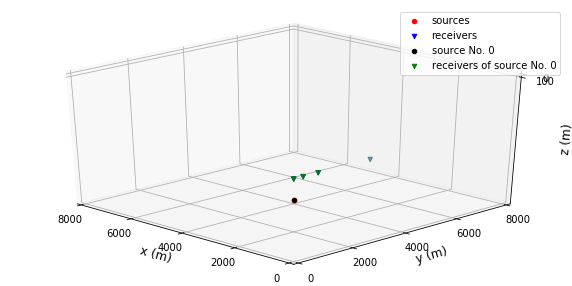

In [37]:
# test acqgeo class
geometry = acqgeo(ids, idr)
geometry.geometry_show(v.x,v.y,v.z,ea=(30,-45))

In [38]:
LRM = LRmodeling(basic_parm,s,geometry,vmh,Qmh,typ_tsc=2,abc={'naABCs': None},inpath=inpath,outpath=outpath)

Cyclic boundary condition...
Absorbing layer No: 0
Runtime for preparing ABCs: 0.18059515953063965 s
Low-rank decomposition...
Ws for W1
RRQR for Ws
Principal Px combinations:[[2.0000000e+03 3.1829926e-03]
 [2.0000000e+03 3.1829926e-03]]
Ws for W2
RRQR for Ws
Principal K components:[0.27139143 0.25887314]
Ws for W1
RRQR for Ws
Principal Px combinations:[[2.0000000e+03 3.1829926e-03]
 [2.0000000e+03 3.1829926e-03]]
Ws for W2
RRQR for Ws
Principal K components:[0.27139143 0.26382378]
Runtime for low-rank decomposition: 11.274583578109741 s
Model parameter calculation...
Modeling preparation done!


In [39]:
st = time.time()
rec,fig,ax = LRM.LRiteration(tsample=[],clim=clim)
T = time.time()-st
print(T)

Source No. progress:
Time progress:


[========================================================================] 100%
[========================================================================] 100%


164.14572262763977


In [40]:
recr = rec

In [41]:
fnr = 'rec_ref.dat'
recr.tofile(f'{outpath}/{fnr}')

## (5) Display the waveforms

In [42]:
rech2 = np.fromfile(f'{outpath}/{fnh2}',dtype=np.float32)
recna1 = np.fromfile(f'{outpath}/{fna1}',dtype=np.float32)
recna2 = np.fromfile(f'{outpath}/{fna2}',dtype=np.float32)
recr = np.fromfile(f'{outpath}/{fnr}',dtype=np.float32)

In [43]:
nr = len(idr)
recr = np.reshape(recr, (nt,nr))
rech2 = np.reshape(rech2, (nt,nr))
recna1 = np.reshape(recna1, (nt,nr))
recna2 = np.reshape(recna2, (nt,nr))

Text(1.1, 0, 'Time (ms)')

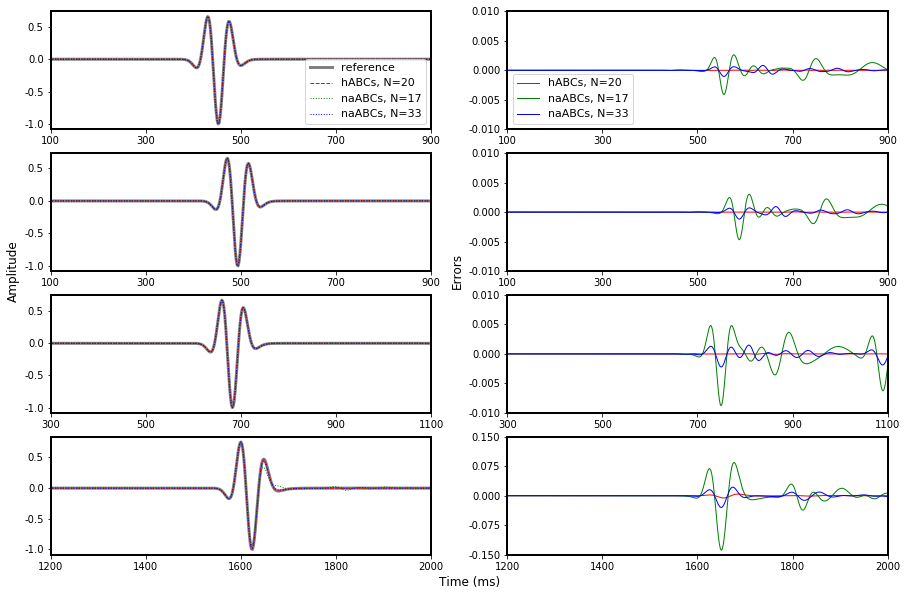

In [44]:
xl = [[50,450],[50,450],[150,550],[600,1000]]
xtk = np.zeros((4,5))
for i in range(4):
    xtk[i,:] = np.linspace(xl[i][0],xl[i][1],5)
ytk = [-1.0,-0.5,0,0.5]
# errors ytick setting
ytk0 = np.array([-0.01,-0.005,0,0.005,0.01])
ytk1 = ytk0
ytk2 = ytk0
ytk3 = np.array([-0.15,-0.075,0,0.075,0.15])
ytke = np.stack((ytk0,ytk1,ytk2,ytk3),axis=0)
# create the waveform comparison
fig,ax = plt.subplots(4,2,figsize=(15,10))
for i in range(4):
    Nl = np.max(np.abs(recr[:,i]))
    recri = recr[:,i]/Nl
    # regular scale comparison
    ax[i,0].plot(recri,c='gray',linewidth=3,label='reference')
    ax[i,0].plot(rech2[:,i]/Nl,c='r',linewidth=1,linestyle='--',label='hABCs, N=20')
    ax[i,0].plot(recna1[:,i]/Nl,c='g',linewidth=1,linestyle=':',label='naABCs, N=17')
    ax[i,0].plot(recna2[:,i]/Nl,c='b',linewidth=1,linestyle=':',label='naABCs, N=33')
    # zoom scale (errors) comparison
    ax[i,1].plot(rech2[:,i]/Nl-recri,c='r',linewidth=1,linestyle='-',label='hABCs, N=20')
    ax[i,1].plot(recna1[:,i]/Nl-recri,c='g',linewidth=1,linestyle='-',label='naABCs, N=17')
    ax[i,1].plot(recna2[:,i]/Nl-recri,c='b',linewidth=1,linestyle='-',label='naABCs, N=33')
    # adjust box weight
    for axis in ['top','bottom','left','right']:
        ax[i,0].spines[axis].set_linewidth(2)
        ax[i,1].spines[axis].set_linewidth(2)
    # adjust display x and y limits
    ax[i,0].set_yticks(ytk)
    ax[i,0].set_yticklabels([f'{i:.1f}' for i in ytk],fontsize=10)
    for j in range(2):
        ax[i,j].set_xlim(xl[i][0],xl[i][1])
        ax[i,j].set_xticks(xtk[i,:])
        ax[i,j].set_xticklabels([f'{int(i*2)}' for i in xtk[i,:]],fontsize=10)
    ax[i,1].set_yticks(ytke[i,:])
    ax[i,1].set_yticklabels([f'{i:.3f}' for i in ytke[i,:]],fontsize=10)
# legends
ax[0,0].legend(loc='lower right',fontsize=11)
ax[0,1].legend(loc='lower left',fontsize=11)
# xylabels
ax[1,0].set_ylabel('Amplitude',fontsize=12,position=(0,0))
ax[1,1].set_ylabel('Errors',fontsize=12,position=(0,0))
ax[3,0].set_xlabel('Time (ms)',fontsize=12,position=(1.1,0))

In [45]:
fig.savefig('./outputs/AGUpaper/wfcomp_abcs.png',dpi=600)

In [46]:
# runtime for preparing ABCs
runtimeabc = np.array([6.55,9.10,1.53])
# runtime for low-rank decomposition
runtimelrd = np.array([1.20,1.89,1.18])
# recorded runtime without plotting snapshots
runtimemod = np.array([9.14,18.98,58.76]) # corresponding to naABCs for vareps=0.04, 0.01 and hABCs for N=20
# when hABCs for N=10, runtime is 31.1s